# Clustering with Max-cut using VQE (versus classical k-means)

Both classical and quantum algorithms are used in classifying the three different dataset.

# Algorithms

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import copy
import seaborn as sns
import matplotlib.pyplot as plt

## A Classical Approach
K-means groups data into k clusters by minimizing each cluster's sum-of-squares 

$$
\sum_{i=0}^{n} \min_{\mu_j \in C}(\lvert\lvert x_i - \mu_j\rvert\rvert^2)
$$

where $\mu_j$ is the mean of the jth cluster within the set $C$ of clusters.

The optimal number of clusters $k$ is known for this data ($k=2$) since the reduced dataset only contains two species. However, let's pretend that's unknown as that would be the case for a real unsupervised learning application.

In [2]:
from sklearn.cluster import KMeans

In [3]:
def kmeans_alg(data, PALLETE):
#data - Dataframe massive without labels
    # Use optimal k for final k-means model
    data1=copy.copy(data)
    optimal_k = 2
    kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(data1)

    # Add k-means labeling to dataframe for later comparison
    data1['label'] = kmeans.labels_

    # Visualize clustering done by k-means algorithm
    sns.pairplot(data=data1, hue='label', palette=PALLETE, vars=data1.columns[:-1])
    plt.show()
    return(data1['label'].values)

## A Quantum Approach


We need map the data to a graph and then the graph optimization problem can then be mapped to a cost Hamiltonian which can be efficiently solved by a quantum computer.

MAX-cut is mapped to an Ising Hamiltonian

We can use QAOA alorithm from Qiskit and VQE method from previous module project forfinding the ground state. 

One approach to unsupervised quantum machine learning is to map the problem to a graph optimization problem (specifically max-cut in this notebook).


### Make a Graph

The first step is to map the data to a graph by calculating the pairwise "distances" between each data point. These distances will weight the edges of the graph. Let's use the $l^2\text{-norm}$ (i.e. vector magnitude).

In [4]:
def weight_return(data): # Get number of data entries
#data - Dataframe massive without labels
    data1=copy.copy(data)
    n_instances = len(data1)

    # Convert dataframe into array
    data_array = data1.values

    # Calculate pairwise L2-norms
    w = np.zeros((n_instances, n_instances))
    for i in range(0, n_instances):
        for j in range(0, n_instances):
            w[i, j] = np.linalg.norm(data_array[i] - data_array[j])

    print('Weight matrix size:', w.shape)
    return(w)

### Cast Max-cut as a Cost Hamiltonian

To separate the graph into clusters, the graph is cut with a max-cut: meaning the graph is separated in two while maximizing the total weight of the 'cut' edges. This is an NP-hard problem. However, it maps to an Ising model, which can be solved efficiently on a quantum computer! By efficiently, I mean it can solve the max-cut problem **FASTER** than a classical computer (theoretically speaking). **That is why this method is so interesting and important.** 


The cost of one cut between nodes $i$ and $j$ is the edge's weight $w_{ij}$ that lies between them. In separating the graph into two sets of nodes ($S_1$ for cluster 1 and $S_2$ for cluster 2), the total weight of a cut $\delta(S)$ is

$$
w(\delta(S)) = \sum_{i\in S_1, j\in S_2} w_{ij}.
$$

Assuming a fully connected graph and accounting for the symmetry of $w_{ij}$ (i.e. $w_{ij} = w_{ji}$), the sum can be expanded to
$$
\begin{align}
w(\delta(S)) & = \frac{1}{2}\sum_{(ij) \in \delta(S_1)} w_{ij} \\
& = \frac{1}{4}\sum_{ij} w_{ij} - \frac{1}{4} \sum_{ij} w_{ij} \hat{\sigma}_i^z \hat{\sigma}_j^z \\
& = \frac{1}{4}\sum_{ij} w_{ij} (1- \hat{\sigma}_i^z \hat{\sigma}_j^z).
\end{align}
$$                 

We can explicitly see it's connection to the Ising Hamiltonian (external field $h = 0$ and irrelevant constant $C$)

$$
H_{ising} = -\sum_{ij}J_{ij}\hat{\sigma}_i^z\hat{\sigma}_j^z + C
$$

where $J_{ij} = \frac{w_{ij}}{4}$. We interpret the output of the Ising model as follows. The spin variables $\hat{\sigma}_i^z \in \{-1, +1\}$ take on the value $\hat{\sigma}_i^z = +1$ for data in cluster 0, and $\hat{\sigma}_i^z = -1$ for data in cluster 1. To solve the optimization problem, the quantum computer finds the ground state of $H_{ising}$ and we're done! There are a variety of algorithms that can find the ground state of a cost Hamiltonian. In this notebook, we will use QAOA and VQE.

The ideas and derivation presented here are directly found in the paper [*Unsupervised Machine Learning on a Hybrid Quantum Computer*](https://arxiv.org/abs/1712.05771).

In [5]:
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator
import scipy,copy
# Quantum Computing packages
from qiskit import BasicAer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA, VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.optimization.applications.ising.common import sample_most_likely

In [6]:
def get_operator(weight_matrix):
    num_nodes = weight_matrix.shape[0]
    pauli_list = []
    shift = 0
    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=np.bool)
                z_p = np.zeros(num_nodes, dtype=np.bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([0.5 * weight_matrix[i, j], Pauli(z_p, x_p)])
                shift -= 0.5 * weight_matrix[i, j]
    return WeightedPauliOperator(paulis=pauli_list), shift

## Solve the Max-cut Problem with using Qiskit algorithm
### QAOA
[QAOA](https://arxiv.org/abs/1411.4028) is a quantum optimizer that will adiabatically find the ground state of a cost Hamiltonian. Qiskit has a QAOA function all ready for us to use. Let's import the packages, initialize the QAOA algorithm with the weights $w$ we previously calculated and run it.

In [7]:
def QAOA_qiskit(data, PALLETE):
# QAOA hyperparameters and initialization
    qubit_ops, offset = get_operator(weight_return(data))  # Compute qubit operations
    data1=copy.copy(data)
    p = 1  # Number of adiabatic steps must be >= 1
    optimizer = COBYLA()  # Classical optimizer
    qaoa = QAOA(qubit_ops, optimizer, p)  # initialize QAOA algorithm

    # Initialize quantum simulator
    backend = BasicAer.get_backend('statevector_simulator')  # Simulate on local machine

    # Initialize quantum computer
    # provider = IBMQ.get_provider(group='open')  # Load provider to access IBM's cloud services
    # backend = provider.get_backend('ibmq_essex')  # Compute on one of IBM's quantum computer

    quantum_instance = QuantumInstance(backend, shots=1)
    
    result = qaoa.run(quantum_instance)
    print(sample_most_likely(result.eigenstate))

    # Extract results
    x = sample_most_likely(result.eigenstate)

    # Extract cluster labels and include them in df_sub
    labels = pd.DataFrame((1-x), columns=['label'])
    data1['label'] = labels

    # Show data by cluster
    sns.pairplot(data=data1,hue='label', palette=PALLETE, vars=df_sub.columns[:-1])
    plt.show()
    return(labels.values)

### VQE
VQE is a quantum optimizer that will find the ground state of a cost Hamiltonian. We can construct quantum computing simulator by our own for showing another way of implementation.


In [8]:
def VQE_qiskit(data, PALLETE):
# VQE hyperparameters and initialization
    qubit_ops, offset = get_operator(weight_return(data))  # Compute qubit operations
    data1=copy.copy(data)
    spsa = SPSA(maxiter=300)
    ry = TwoLocal(qubit_ops.num_qubits, 'ry', 'cz', reps=2, entanglement='linear')
    backend = BasicAer.get_backend('statevector_simulator')  # Simulate on local machine

    quantum_instance = QuantumInstance(backend, shots=1)

    vqe = VQE(qubit_ops, ry, spsa, quantum_instance=quantum_instance)

    result = vqe.run(quantum_instance)
    print(sample_most_likely(result.eigenstate))
    # Extract results
    x = sample_most_likely(result.eigenstate)

    # Extract cluster labels and include them in df_sub
    labels = pd.DataFrame((1-x), columns=['label'])
    data1['label'] = labels

    # Show data by cluster
    sns.pairplot(data=data1,hue='label', palette=PALLETE, vars=data1[:-1])
    plt.show()
    return(labels.values)

### NumPyMinimumEigensolver

In [9]:
def NumPyMinimumEigensolver_qiskit(data, PALLETE):
# NumPyMinimumEigensolver
    qubit_ops, offset = get_operator(weight_return(data))  # Compute qubit operations
    data1=copy.copy(data)
    NPME = NumPyMinimumEigensolver(qubit_ops)  # initialize QAOA algorithm
    result = NPME.run()
    print(sample_most_likely(result.eigenstate))

    # Extract results
    xx = sample_most_likely(result.eigenstate)
    # Extract cluster labels and include them in df_sub
    labels = pd.DataFrame((1-xx), columns=['label'])
    data1['label'] = labels

    # Show data by cluster
    sns.pairplot(data=data1,hue='label', palette=PALLETE, vars=data1.columns[:-1])
    plt.show()
    return(labels.values)

## VQE from module 2 project

Let's construct quantum computing simulator.

In [10]:
def XGate(): return np.array([[0.0,1.0],[1.0,0.0]])

def YGate(): return np.array([[0.0,-1.0j],[1.0j,0.0]])

def ZGate(): return np.array([[1.0,0.0],[0.0,-1.0]])

def apply_gate(gate, qbit, phi):
    """
    Apply quantum gate to a statevector for a given qbit.
    Argument:
        gate: 2x2 matrix of the gate.
        qbit: index of qbit affected by the gate.
        phi: statevector in the form of 2x2x2x...x2 array.
    """
    nq = phi.ndim
    assert qbit<nq    
    idx = list(range(nq))
    idx[qbit] = nq
    return np.einsum(gate, [nq, qbit], phi, list(range(nq)), idx)

def apply_controlled_gate(control, gate, qbit, phi):
    """
    Apply controlled quantum gate to a statevector for a given qbit.
    Argument:
        control: control bit.
        gate: 2x2 matrix of the gate.
        qbit: index of qbit affected by the gate.
        phi: statevector in the form of 2x2x2x...x2 array.
    """
    nq = phi.ndim
    assert control<nq and qbit<nq and control!=qbit
    prefix = (slice(None),)*control
    psi0 = phi[prefix+(0,None)] # Action if control is zero.
    idx = list(range(nq))
    idx[qbit] = nq
    psi1 = np.einsum(gate, [nq, qbit], phi[prefix+(1,None)], list(range(nq)), idx) # Action if control 1.
    return np.concatenate((psi0,psi1), axis=control)


def Rx(theta): return np.cos(theta/2)*np.array([[1.0,0.0],[0.0,1.0]])-1j*np.sin(theta/2)*XGate()
def Ry(theta): return np.cos(theta/2)*np.array([[1.0,0.0],[0.0,1.0]])-1j*np.sin(theta/2)*YGate()
def Rz(theta): return np.cos(theta/2)*np.array([[1.0,0.0],[0.0,1.0]])-1j*np.sin(theta/2)*ZGate()

def inner(a,b):# return np.sum(np.conj(a), b)
    return np.dot(np.conj(a.flatten()), b.flatten())

Let's construct VQE circuit for finding energy of ground state.

In [11]:
# Let's construct VQE circuit for finding energy of ground state.
def VQE_circuit(theta, n, depth,NUMN_rott,phi0,hami,coefi): 
    #theta - argument for optimixation
    #n -number of qbits
    #depth - depth for hardware anzatz
    #NUMN_rott - number of rotation operator per step on qbit.
    
    theta=np.reshape(theta,(1+depth,n,NUMN_rott))
    phi=copy.copy(phi0)

    # Put all the qbits in the |+> state
    for i in range(n):
        phi=apply_gate(Ry(theta[0][i][0]),i,phi)
        if NUMN_rott>=2:
            phi=apply_gate(Ry(theta[0][i][1]),i,phi)
        if NUMN_rott==3:
            phi=apply_gate(Ry(theta[0][i][2]),i,phi)
            
    # Now introduce the z-gates and R-gates 'depth' times
    for j in range(depth):
        # Apply controlled-z gates
        for i in range(n-1):
            phi=apply_controlled_gate(i,ZGate(),i+1,phi)
            
        # Introduce RY-gates
        for i in range(n):
            phi=apply_gate(Ry(theta[j+1][i][0]),i,phi)
            if NUMN_rott>=2:
                phi=apply_gate(Rx(theta[j+1][i][1]),i,phi)
            if NUMN_rott==3:
                phi=apply_gate(Rz(theta[j+1][i][2]),i,phi)
            
    phi_right=copy.copy(phi)
    E=0
    for i in range(len(coefi)):
        phi_right=copy.copy(phi)
        for g in range(len(hami[i])):
            if hami[i][g][0]=='Z':
                phi_right=apply_gate(ZGate(),hami[i][g][1],phi_right)
        E=E+np.real(coefi[i]*inner(phi,phi_right))
    
    return E 
# Function for evaluate ground state
def fu_cir(theta,n,depth,NUMN_rott,phi0,hami,coefi):
    theta=np.reshape(theta,(1+depth,n,NUMN_rott))
    phi=copy.copy(phi0)

    for i in range(n):
        phi=apply_gate(Ry(theta[0][i][0]),i,phi)
        if NUMN_rott>=2:
            phi=apply_gate(Ry(theta[0][i][1]),i,phi)
        if NUMN_rott==3:
            phi=apply_gate(Ry(theta[0][i][2]),i,phi)
    # Now introduce the z-gates and RY-gates 'depth' times
    for j in range(depth):
        # Apply controlled-z gates
        for i in range(n-1):
            phi=apply_controlled_gate(i,ZGate(),i+1,phi)
        # Introduce RY-gates
        for i in range(n):
            phi=apply_gate(Ry(theta[j+1][i][0]),i,phi)
            if NUMN_rott>=2:
                phi=apply_gate(Rx(theta[j+1][i][1]),i,phi)
            if NUMN_rott==3:
                phi=apply_gate(Rz(theta[j+1][i][2]),i,phi)
    return sample_most_likely(phi.flatten())

VQE algorithm

In [12]:
def VQE_module2(data,PALLETE):
# NumPyMinimumEigensolver
    qubit_ops, offset = get_operator(weight_return(data))  # Compute qubit operations
    data1=copy.copy(data)    
    NQBITS=qubit_ops.num_qubits
    infor=qubit_ops.to_dict()['paulis']
    hami=[]
    coefi=[]
    for t in infor:
            zamm=[]
            coefi.append(np.float(t['coeff']['real']))
            for i,val in enumerate(t['label']):
                if val=='Z':
                    #zamm.append([val,i])
                    zamm.append([val,NQBITS-1-i])
            hami.append(zamm)
    #prepare initial function
    
    dime=np.array(2*np.ones(NQBITS), dtype='int')
    phi0=np.zeros(2**NQBITS)
    phi0[0]=(1.0)
    #phi0=phi0.reshape(dime)
    phi0=phi0.reshape(dime)
    
#parametrs of VQE    
    DEPTH=1
    NUMB_rot=1
    METHOD='COBYLA'
    x0=np.random.random(NQBITS*NUMB_rot*(1+DEPTH))
    for i in range(NQBITS*NUMB_rot):
        x0[i]=np.pi/2/NQBITS
    ans=scipy.optimize.minimize(fun=VQE_circuit, x0=x0, method=METHOD, tol=10**(-6), options= {"maxiter": 8000}, args=(NQBITS,DEPTH,NUMB_rot,phi0,hami,coefi))#,jac=jacob)
    Energ_vqe=ans.fun
    print('energy=', Energ_vqe, '№int=',ans.nfev)
    #print(ans)    
    # Extract results
    xx = fu_cir(ans.x,n=NQBITS, depth=DEPTH, NUMN_rott=NUMB_rot,phi0=phi0,hami=hami,coefi=coefi)
    print(xx)
    # Extract cluster labels and include them in df_sub
    labels = pd.DataFrame((1-xx), columns=['label'])
    data1['label'] = labels

    # Show data by cluster
    sns.pairplot(data=data1,hue='label', palette=PALLETE, vars=data1.columns[:-1])
    plt.show()
    return(labels.values)

# DIFFERENT DATASETS

## IRIS DATASET

This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica), stored in a 150x4 numpy.ndarray.

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, Robert Fisher developed a linear discriminant model to distinguish the species from each other.

### Original papers:
R. A. Fisher (1936). "The use of multiple measurements in taxonomic problems". Annals of Eugenics. 7 (2): 179–188. doi:10.1111/j.1469-1809.1936.tb02137.x.

Edgar Anderson (1936). "The species problem in Iris". Annals of the Missouri Botanical Garden. 23 (3): 457–509. doi:10.2307/2394164.JSTOR2394164

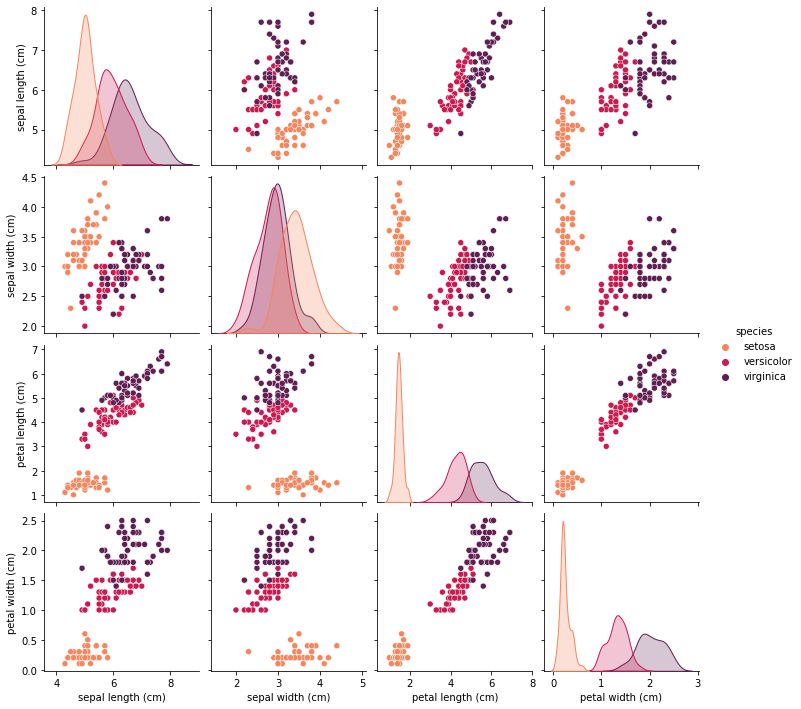

In [13]:
# Import Iris dataset
iris_data = load_iris()
dataframe = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
dataframe['species'] = pd.Categorical.from_codes(iris_data.target, iris_data.target_names).astype(str)

# View data with known labels as a control to compare future clustering done by k-means and Max-cut
sns.pairplot(data=dataframe, hue="species", palette="rocket_r")
plt.show()

We want to compare classical k-means with standard Max-cut problem. For that, we should consider **datasets with only two clusters**. 

Moreover, concerning memory and time limitations, we should **reduced datasets** to sets with only 6-15 points to simulate the work of quantum computers on laptops.

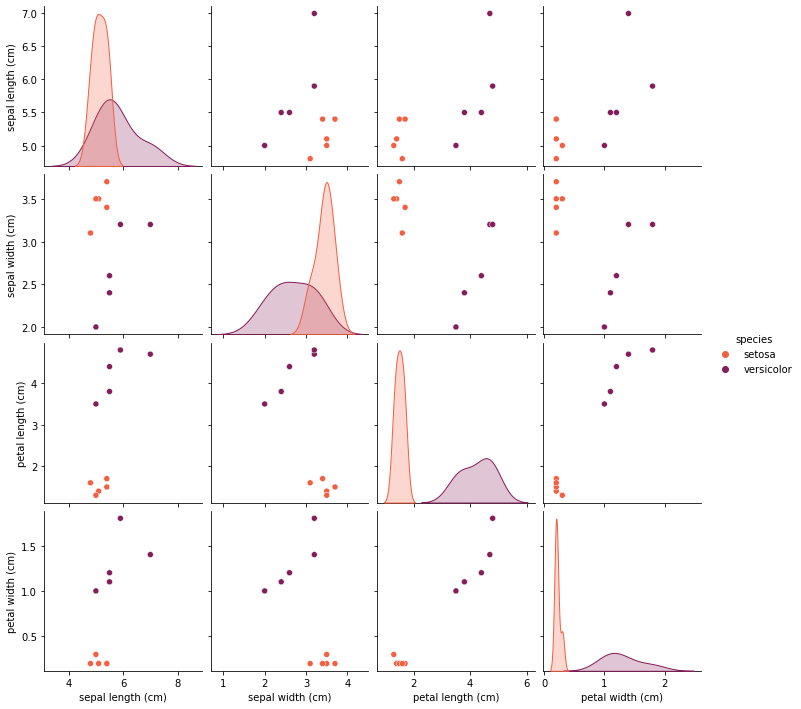

In [14]:
# Generate subset of data with fewer data points
df_sub = dataframe.iloc[::10,:].reset_index(drop=True)

# Constrain data to 2 species
df_sub = df_sub.loc[(df_sub['species'] == 'setosa') | (df_sub['species'] == 'versicolor')]
df_sub_labels = df_sub.loc[:,['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']]
sns.pairplot(data=df_sub, hue="species", palette="rocket_r")
plt.show()

classical k-means


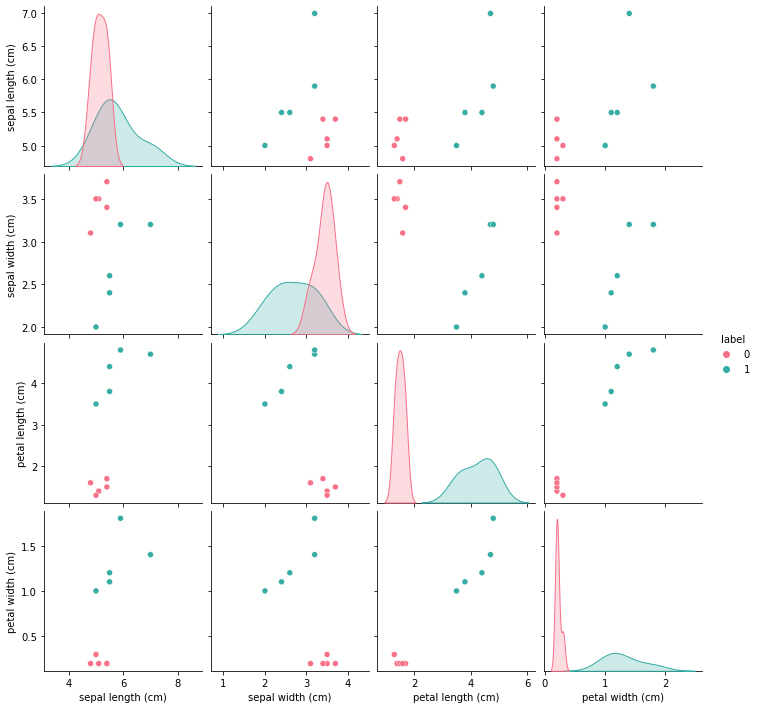

VQE from Module2
Weight matrix size: (10, 10)
energy= -30.615912398925772 №int= 7089
[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


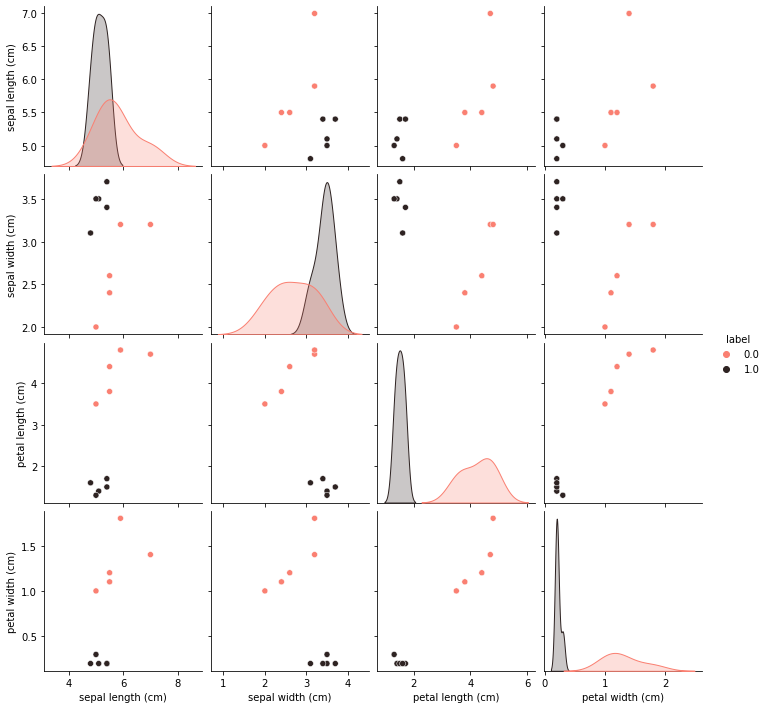

VQE from Qiskit
Weight matrix size: (10, 10)
[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


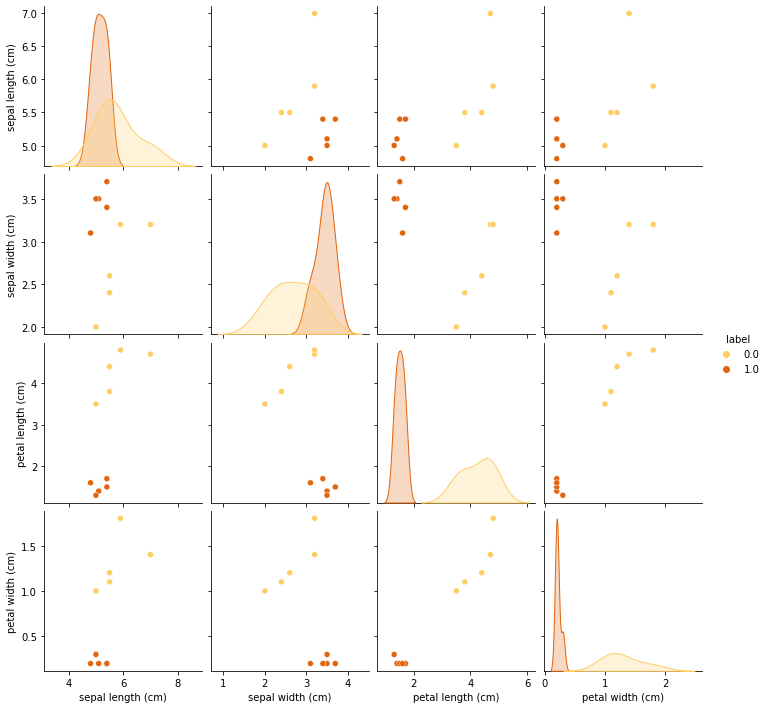

QAOA from Qiskit
Weight matrix size: (10, 10)
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]


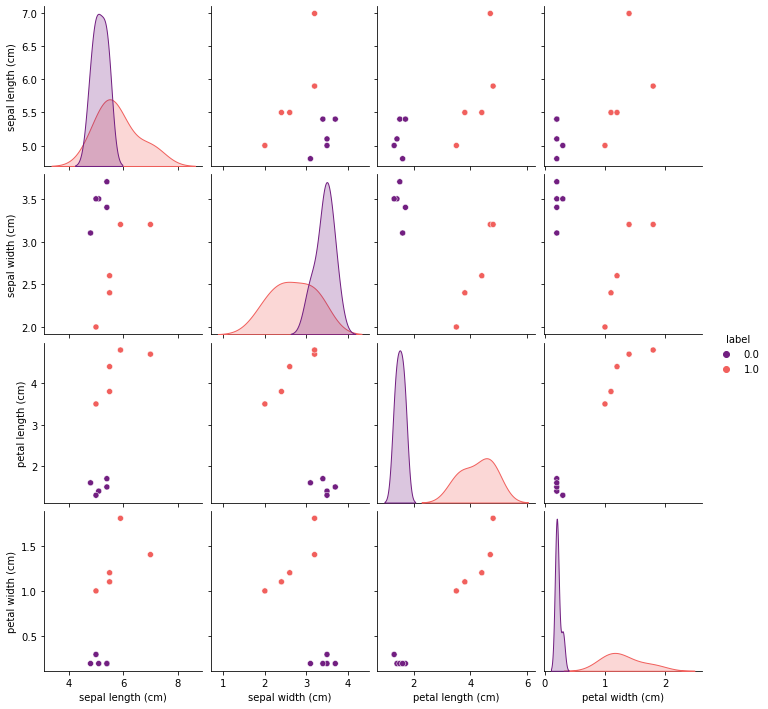

NumPyMinimumEigensolver from Qiskit
Weight matrix size: (10, 10)
[1 1 1 1 1 0 0 0 0 0]


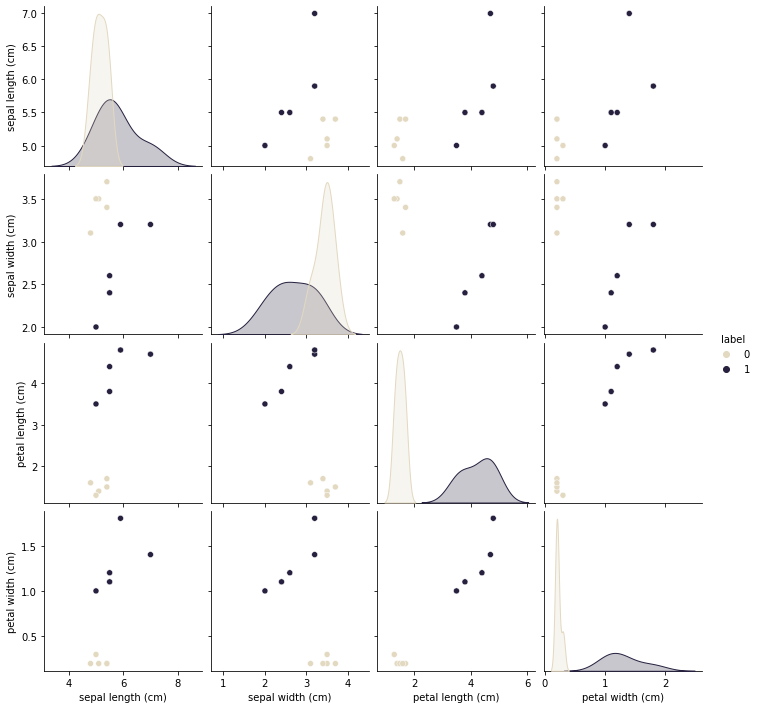

In [15]:
#start with classical k-means 
print('classical k-means')
PALLETE = "husl"
x_cl = kmeans_alg(df_sub_labels,PALLETE)

print('VQE from Module2')
#VQE from Module2
PALLETE = "dark:salmon_r"
x_vqe_q = VQE_module2(df_sub_labels,PALLETE)

print('VQE from Qiskit')
#VQE from Qiskit
PALLETE = "YlOrBr"
x_vqe_q = VQE_qiskit(df_sub_labels,PALLETE)

print('QAOA from Qiskit')
#QAOA from Qiskit
PALLETE = "magma"
x_vqe_q = QAOA_qiskit(df_sub_labels,PALLETE)

print('NumPyMinimumEigensolver from Qiskit')
#NumPyMinimumEigensolver from Qiskit
PALLETE = "ch:s=-.2,r=.6"
x_vqe_q = NumPyMinimumEigensolver_qiskit(df_sub_labels,PALLETE)

For 10 qbits k-means and Max-cut give te same result. 10/10 points have the right labels. In terms of metrics:

Precision **P=1**

Recall **R=1**

**But honestly speaking, real limits for simulations on my laptop is NQBIT=15. Let's consider iris sets (and another) with 15 points.**

Qiskit VQE and QAOA has memory limitation in this case.

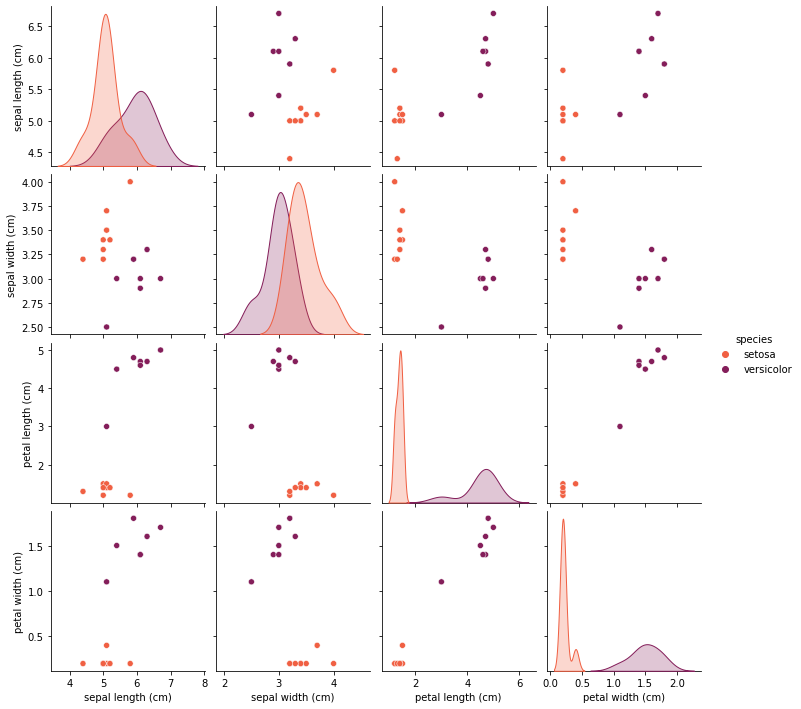

In [16]:
# Generate subset of data with fewer data points
df_sub = dataframe.iloc[::7,:].reset_index(drop=True)

# Constrain data to 2 species
df_sub = df_sub.loc[(df_sub['species'] == 'setosa') | (df_sub['species'] == 'versicolor')]
df_sub_labels = df_sub.loc[:,['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']]
sns.pairplot(data=df_sub, hue="species", palette="rocket_r")
plt.show()

classical k-means


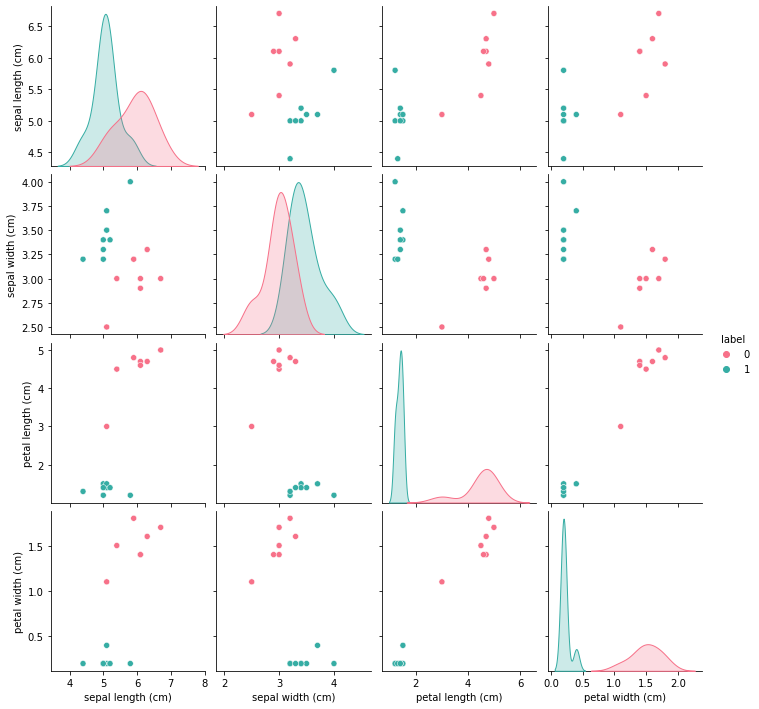

VQE from Module2
Weight matrix size: (15, 15)
energy= -80.4415887189996 №int= 2232
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


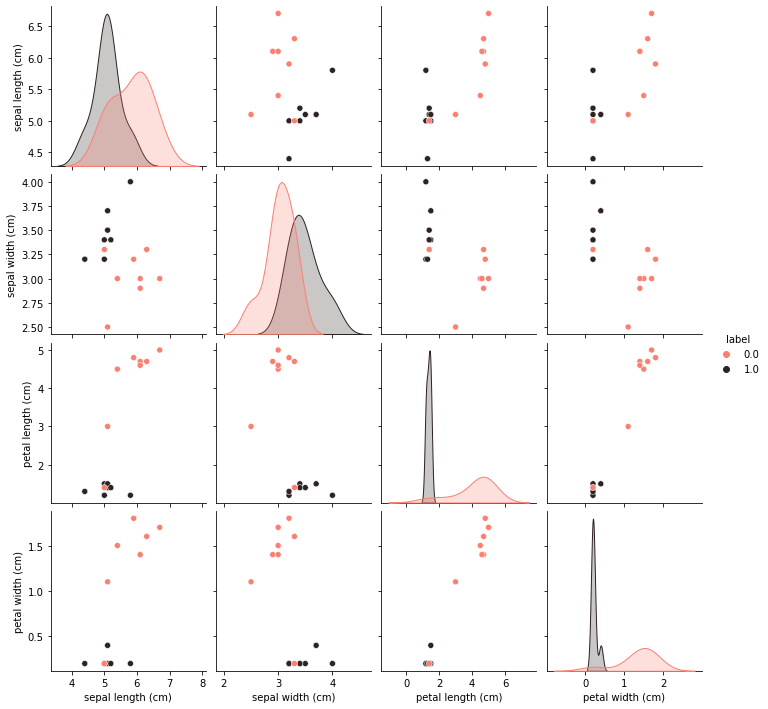

NumPyMinimumEigensolver from Qiskit
Weight matrix size: (15, 15)
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


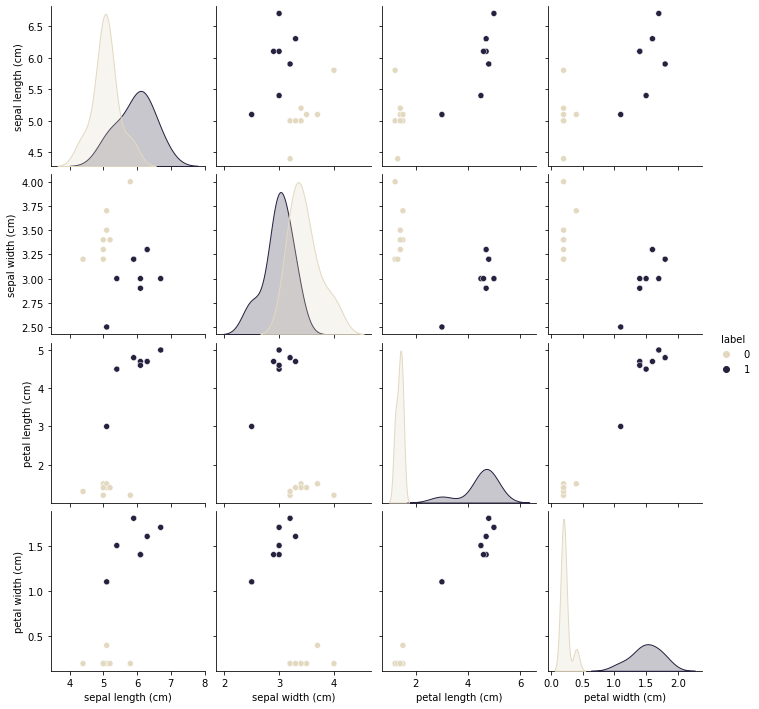

In [17]:
#start with classical k-means 
print('classical k-means')
PALLETE = "husl"
x_cl = kmeans_alg(df_sub_labels,PALLETE)

print('VQE from Module2')
#VQE from Module2
PALLETE = "dark:salmon_r"
x_vqe_q = VQE_module2(df_sub_labels,PALLETE)

print('NumPyMinimumEigensolver from Qiskit')
#NumPyMinimumEigensolver from Qiskit
PALLETE = "ch:s=-.2,r=.6"
x_vqe_q = NumPyMinimumEigensolver_qiskit(df_sub_labels,PALLETE)

For 15 qbits k-means and Max-cut NumPyMinimumEigensolver_qiskit give te same result. 15/15 points have the right labels. In terms of metrics:

Precision **P=1**

Recall **R=1**

Max-Cut VQE_module2 (with depth=1 (and for =2,3,4)) returns right labels for 14/15 points. In term of metrics:

Precision **P=0.9**

Recall **R=0.9**

# FLAME DATASET

This is two clusters datasets with x,y coordinates.

**Origin paper**:

L. Fu and E. Medico, FLAME, a novel fuzzy clustering method for the analysis of DNA microarray data. BMC bioinformatics, 2007. 8(1): p. 3.

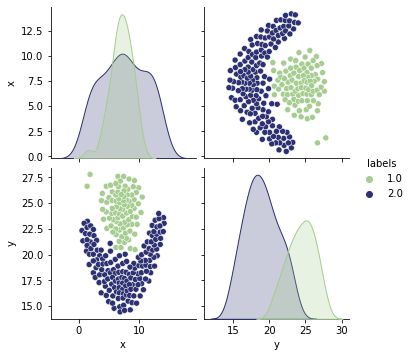

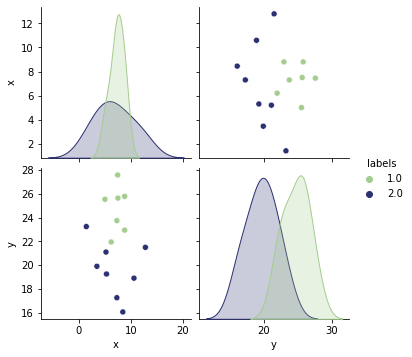

In [18]:
GT0=np.loadtxt('flame.txt')
df0_origin = pd.DataFrame({'x':GT0[:,0],'y':GT0[:,1], 'labels':GT0[:,2]})
sns.pairplot(df0_origin, hue='labels', palette="crest", vars=df0_origin.columns[:-1])
plt.show()

#reducing to 15 points
GT0a=GT0[:152,:]
GT0a=GT0a[::22,:]
GT0b=GT0[152:,:]
GT0b=GT0b[::12,:]
GTT0=np.concatenate((GT0a,GT0b))
df0 = pd.DataFrame({'x':GTT0[:,0],'y':GTT0[:,1]})
df1=copy.copy(df0)
df1['labels']=GTT0[:,2]
sns.pairplot(df1, hue='labels', palette="crest", vars=df1.columns[:-1])

classical k-means


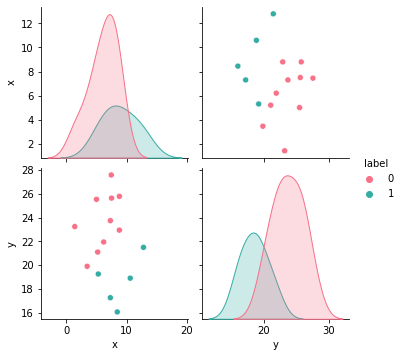

In [20]:
#start with classical k-means 
print('classical k-means')
PALLETE = "husl"
x_cl = kmeans_alg(df0,PALLETE)

For 15 pionts k-means gives right result for 12/15 points have the right labels. In terms of metrics:

Precision **P=0.7**

Recall **R=0.6**

VQE from Module2
Weight matrix size: (15, 15)
energy= -81.76431234100652 №int= 8000
[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]


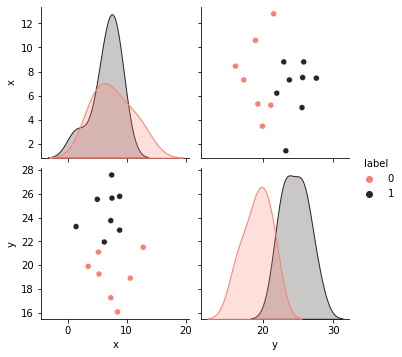

NumPyMinimumEigensolver from Qiskit
Weight matrix size: (15, 15)
[0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


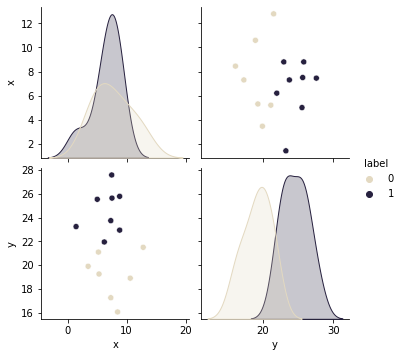

In [21]:
print('VQE from Module2')
#VQE from Module2
PALLETE = "dark:salmon_r"
x_vqe_q = VQE_module2(df0,PALLETE)

print('NumPyMinimumEigensolver from Qiskit')
#NumPyMinimumEigensolver from Qiskit
PALLETE = "ch:s=-.2,r=.6"
x_nqe_q = NumPyMinimumEigensolver_qiskit(df0,PALLETE)

Max-Cut VQE_module2 (with depth=1 (and for =2,3,4)) and Max-cut NumPyMinimumEigensolver_qiskit return right labels for 14/15 points. In term of metrics:

Precision **P=0.9**

Recall **R=0.9**

# JANE DATASET

This is two clusters datasets with x,y coordinates.

**Origin paper**:

A. Jain and M. Law, Data clustering: A user's dilemma. Lecture Notes in Computer Science, 2005. 3776: p. 1-10.

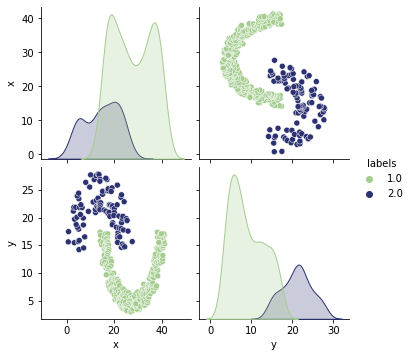

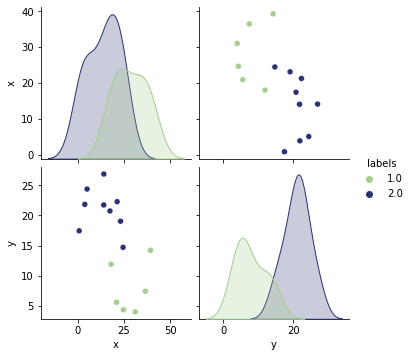

In [22]:
GT=np.loadtxt('jain.txt')
df01_origin = pd.DataFrame({'x':GT[:,0],'y':GT[:,1], 'labels':GT[:,2]})
sns.pairplot(df01_origin, hue='labels', palette="crest", vars=df01_origin.columns[:-1])
plt.show()

GTa=GT[:96,:]
GTa=GTa[::12,:]
GTb=GT[96:,:]
GTb=GTb[::41,:]
GTT=np.concatenate((GTa,GTb))

df00 = pd.DataFrame({'x':GTT[:,0],'y':GTT[:,1]})
df01=copy.copy(df00)
df01['labels']=GTT[:,2]
sns.pairplot(df01, hue='labels', palette="crest", vars=df01.columns[:-1])

classical k-means


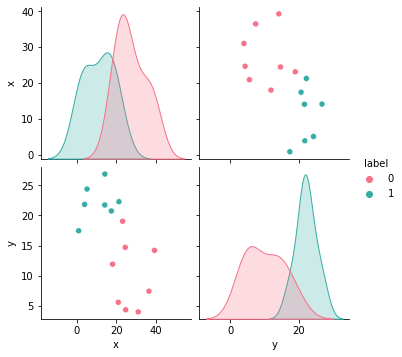

In [24]:
#start with classical k-means 
print('classical k-means')
PALLETE = "husl"
x_cl = kmeans_alg(df00,PALLETE)

For 15 pionts k-means gives right result for 13/15 points have the right labels. In terms of metrics:

Precision **P=0.8**

Recall **R=0.7**

VQE from Module2
Weight matrix size: (15, 15)
energy= -329.04244118714 №int= 7794
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]


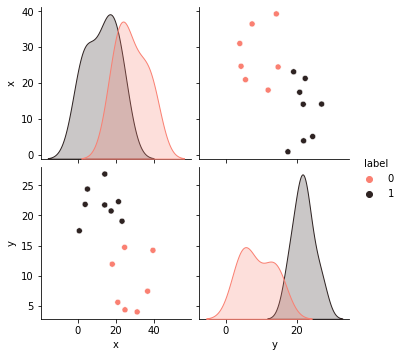

NumPyMinimumEigensolver from Qiskit
Weight matrix size: (15, 15)
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]


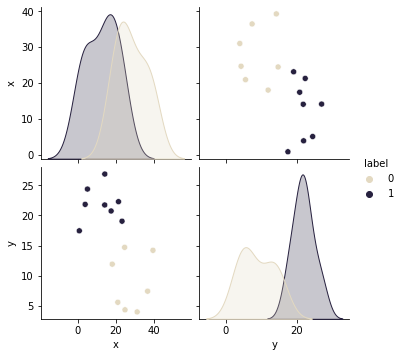

In [25]:
print('VQE from Module2')
#VQE from Module2
PALLETE = "dark:salmon_r"
x_vqe_q = VQE_module2(df00,PALLETE)

print('NumPyMinimumEigensolver from Qiskit')
#NumPyMinimumEigensolver from Qiskit
PALLETE = "ch:s=-.2,r=.6"
x_vqe_q = NumPyMinimumEigensolver_qiskit(df00,PALLETE)

Max-Cut VQE_module2 (with depth=1 (and for =2,3,4)) and Max-cut NumPyMinimumEigensolver_qiskit return right labels for 14/15 points. In term of metrics:

Precision **P=0.9**

Recall **R=0.9**